# Import packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import EELScodes
import dm4reader
import dm4test.test_dm4
import types
import sklearn.decomposition
import copy 

Using TensorFlow backend.


# Configuration

In [4]:
xlimits=[70,140]
maxeV=750
maxeV=(maxeV-300)*2

backgroundregion=np.arange(80,180,1)
activeregion=np.arange(182,222,1)

postfix='_lesscut_sg_2dSG_edit'

# Load data

In [5]:
eelsdata='EELS Spectrum Image.dm4'
data=types.SimpleNamespace()

dm4data = dm4reader.DM4File.open(eelsdata)

tags = dm4data.read_directory()
image_data_tag = tags.named_subdirs['ImageList'].unnamed_subdirs[1].named_subdirs['ImageData']
image_tag = image_data_tag.named_tags['Data']
#print(tags)

XDim = dm4data.read_tag_data(image_data_tag.named_subdirs['Dimensions'].unnamed_tags[0])
YDim = dm4data.read_tag_data(image_data_tag.named_subdirs['Dimensions'].unnamed_tags[1])
#print(XDim)
data.I = np.array(dm4data.read_tag_data(image_tag), dtype=np.uint16)
data.I = np.reshape(data.I, (-1,YDim, XDim))
data.I = np.swapaxes(data.I,0,2)
data.I = np.swapaxes(data.I,0,1)
#output_fullpath = "sample.tif"
#image = PIL.Image.fromarray(np_array, 'I;16')
#image.save(output_fullpath)
#dm4test.test_dm4.print_tag_directory_tree(dm4data,tags)
data.I=data.I[:,:,:maxeV]
shape=data.I.shape
#print(data.I.shape)
data.E=np.arange(data.I.shape[2])*0.5+300
print(data.I.shape)

(146, 228, 900)


# SG-filtering

In [6]:
#1d spectral filter
data.I=EELScodes.savgol(np.float64(np.copy(data.I)), num_to_remove=3, window_length=5, polyorder=3,fit_type='linear')
data.I=data.I.reshape(shape)
#2d filter for each image
tempdata=[]
for i in range(data.I.shape[2]):
    tempdata.append(EELScodes.sgolay2d(data.I[:,:,i],window_length=5, polyorder=3))
data.I=np.array(tempdata)
data.I = np.swapaxes(data.I,0,2)
data.I = np.swapaxes(data.I,0,1)
print(data.I.shape)

(146, 228, 900)


# Plot image and cut to area of interest

Text(0.5, 1.0, 'Area of interest')

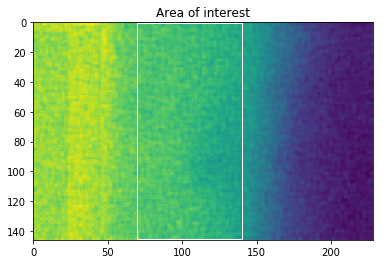

In [7]:
fig= plt.figure(figsize=(12,4))
ax=fig.subplots(1,1)
ax.pcolor(data.I[:,:,0])
ax.axis('scaled')
ax.invert_yaxis()
ax.plot(xlimits,[0.5,0.5],color=[1,1,1,1],lw=1)
ax.plot([xlimits[0],xlimits[0]],[0.5,data.I.shape[0]-0.5],color=[1,1,1,1],lw=1)
ax.plot([xlimits[1],xlimits[1]],[0.5,data.I.shape[0]-0.5],color=[1,1,1,1],lw=1)
ax.plot(xlimits,[data.I.shape[0]-0.5,data.I.shape[0]-0.5],color=[1,1,1,1],lw=1)
ax.set_title('Area of interest')

In [8]:
data.I=data.I[:,xlimits[0]:xlimits[1],:]

# Backround subtraction based on power law fit of selected region

Text(300, 10000, 'Background subtration based on \nfit to colored region of spectra')

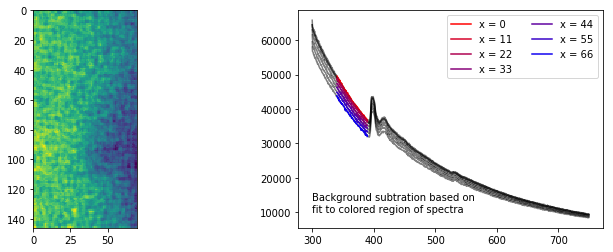

In [9]:
fig= plt.figure(figsize=(12,4))
ax=fig.subplots(1,2)
ax[0].pcolor(data.I[:,:,0])
ax[0].axis('scaled')
ax[0].invert_yaxis()
xlen=data.I.shape[1]
for i in np.arange(0,xlen,xlen//6):
    color=[1*(xlen-i)/xlen,0,1*i/xlen,1]
    DataLineSum=np.sum(data.I[:,i,:], axis=0)
    ax[1].plot(data.E,DataLineSum,color=[0,0,0,0.5])
    DataLineSum=np.sum(data.I[:,i,backgroundregion], axis=0)
    ax[1].plot(data.E[backgroundregion],DataLineSum,color=color,label='x = '+str(i))
ax[1].legend(fontsize=10,ncol=2)
ax[1].text(300,10000,'Background subtration based on \nfit to colored region of spectra')

In [10]:
data.subbed=EELScodes.subtractExpBackground(data.I[:,:,:],backgroundregion)

# Cut data to region of interest

In [11]:
data.subbedCut=data.subbed[:,:,activeregion]
data.ECut=data.E[activeregion]

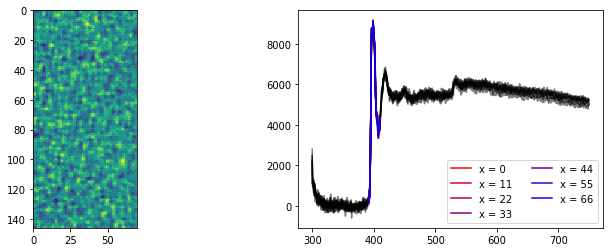

In [12]:
fig= plt.figure(figsize=(12,4))
ax=fig.subplots(1,2)
ax[0].pcolor(data.subbedCut[:,:,0])
ax[0].axis('scaled')
ax[0].invert_yaxis()
xlen=data.I.shape[1]
for i in np.arange(0,xlen,xlen//6):
    color=[1*(xlen-i)/xlen,0,1*i/xlen,1]
    DataLineSum=np.sum(data.subbed[:,i,:], axis=0)
    ax[1].plot(data.E,DataLineSum,color=[0,0,0,0.5])
    DataLineSum=np.sum(data.subbedCut[:,i,:], axis=0)
    ax[1].plot(data.ECut,DataLineSum,color=color,label='x = '+str(i))
ax[0].plot(xlimits,[100,100])
ax[1].legend(fontsize=10,ncol=2)

# Normalize data

In [13]:
data.subbedCutNorm, data.std, data.mean=EELScodes.normalize(data.subbedCut,extra_output=True)

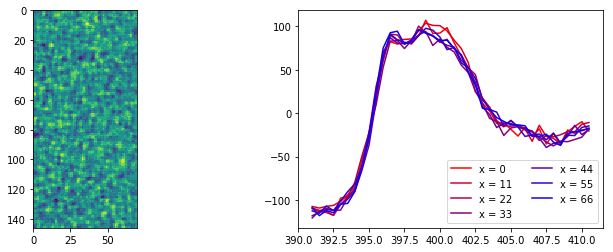

In [14]:
fig= plt.figure(figsize=(12,4))
ax=fig.subplots(1,2)
ax[0].pcolor(data.subbedCutNorm[:,:,0])
ax[0].axis('scaled')
ax[0].invert_yaxis()
xlen=data.I.shape[1]
for i in np.arange(0,xlen,xlen//6):
    color=[1*(xlen-i)/xlen,0,1*i/xlen,1]
    DataLineSum=np.sum(data.subbedCutNorm[i,:,:], axis=0)
    ax[1].plot(data.ECut,DataLineSum,color=color,label='x = '+str(i))
ax[0].plot(xlimits,[100,100])
ax[1].legend(fontsize=10,ncol=2)

In [15]:
trainingforML=data.subbedCutNorm
# we do not use a validation set

# Set up and run NMF

In [16]:
numNMFcomp=4


    
NMFmodel = sklearn.decomposition.NMF(n_components=numNMFcomp, init='random',
            random_state=0, alpha=1e-7, l1_ratio=1)
# computes the nmf

sha=data.subbedCutNorm.shape

data_for_nmf=data.subbedCutNorm.reshape((-1,sha[2]))
NMFcomponents = NMFmodel.fit_transform(np.rollaxis(data_for_nmf - np.min(data_for_nmf), 1))
NMFcomponents = np.swapaxes(NMFcomponents,0,1)

NMFembeddings = np.rollaxis(NMFmodel.components_, 1)
NMFembeddings=NMFembeddings.reshape((sha[0],sha[1],numNMFcomp))
#PCA=PCA[0].reshape((xlen,xlen,numV))


# Plot NMF maps

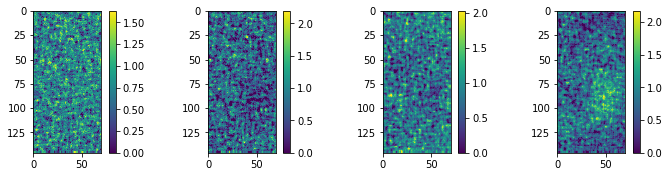

In [17]:
fig= plt.figure(figsize=(12,12))
ax=[]
for i,component in enumerate(NMFcomponents):
    ax.append(fig.add_subplot(4,4,i+1))
    pcolor=ax[-1].pcolor(NMFembeddings[:,:,i])
    ax[-1].axis('scaled')
    ax[-1].invert_yaxis()
    #pcolor.set_clim(0, 2)
    fig.colorbar(pcolor)

# Plot NMF components

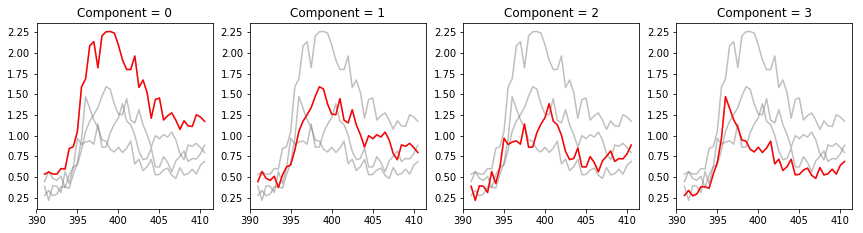

In [18]:

fig= plt.figure(figsize=(12,12))
ax=[]
for i,component in enumerate(NMFcomponents):
    ax.append(fig.add_subplot(4,4,i+1))
    #ax[i].plot(data.ECut,PCA[0].mean_,color=[0,0,0,0.5])
    #weight=np.max(PCAembeddings[:,:,i])
    for j,c in enumerate(NMFcomponents):
        ax[i].plot(data.ECut,c,color=[0.5,0.5,0.5,0.5])
    ax[i].plot(data.ECut,component,color=[1,0,0,1])
    ax[i].set_title('Component = '+str(i))
fig.tight_layout()

# Plot pixels with highest factor in each componet

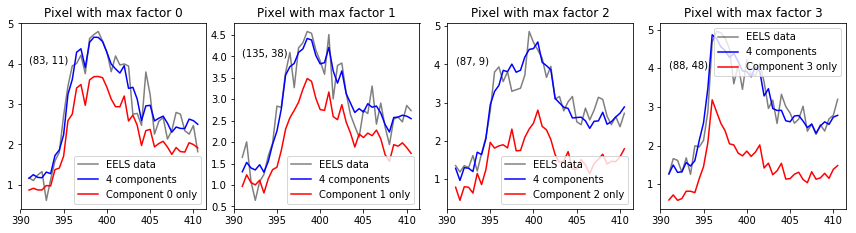

In [19]:
eigenvectors=NMFcomponents
fig= plt.figure(figsize=(12,12))
ax=[]
#fig.suptitle('Datapoints with highest score for each component')
for i,eigenvector in enumerate(eigenvectors):
    ax.append(fig.add_subplot(4,4,i+1))
    indexes=np.unravel_index(np.argmax(NMFembeddings[:,:,i], axis=None), NMFembeddings[:,:,i].shape)
    ax[i].text(391,4,indexes)
    #ax[i].plot(data.ECut,PCA[0].mean_,color=[0,0,0,0.5])
    ax[i].plot(data.ECut,trainingforML[indexes]-np.min(trainingforML),color=[0,0,0,0.5],label='EELS data')
    
    predicted=np.dot(NMFembeddings[indexes], eigenvectors)
    #predicted=NMFmodel.inverse_transform([[0,0,0,1])
    ax[i].plot(data.ECut,predicted,color=[0,0,1,1],label=str(numNMFcomp)+' components')
    weight=NMFembeddings[indexes][i]
    ax[i].plot(data.ECut,eigenvector*weight,color=[1,0,0,1],label='Component '+str(i)+' only')
    ax[i].set_title('Pixel with max factor '+str(i))
    ax[i].legend()
fig.tight_layout()

# Set up and run PCA

In [20]:
numPCAcomp=4

sha=data.subbedCutNorm.shape
pca = sklearn.decomposition.PCA(n_components=numPCAcomp)
PCA = pca.fit(data.subbedCutNorm.reshape((-1,sha[2])))
PCAembeddings=PCA.transform(data.subbedCutNorm.reshape((-1,sha[2])))[:, 0:numPCAcomp].reshape((sha[0],sha[1],-1))

# Plot PCA maps

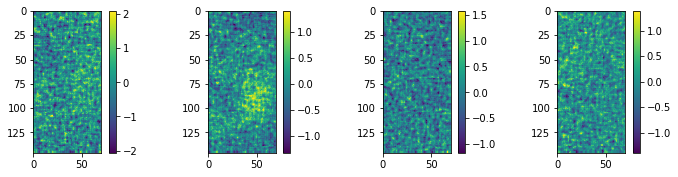

In [21]:
fig= plt.figure(figsize=(12,12))
ax=[]
for i in range(numPCAcomp):
    ax.append(fig.add_subplot(4,4,i+1))
    pcolor=ax[-1].pcolor(PCAembeddings[:,:,i])
    ax[-1].axis('scaled')
    ax[-1].invert_yaxis()
    #pcolor.set_clim(0, 2)
    fig.colorbar(pcolor)

# Plot PCA components

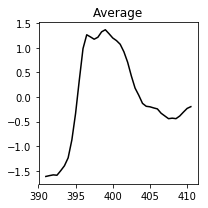

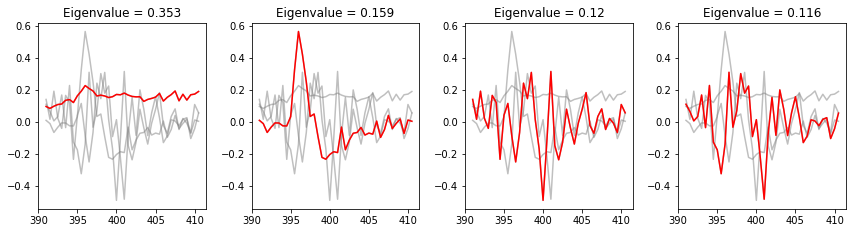

In [22]:
#eigenvectors=PCA[0].components_
fig= plt.figure(figsize=(3,3))
ax=fig.subplots(1,1)
ax.plot(data.ECut,PCA.mean_,color=[0,0,0,1])
ax.set_title('Average')
fig.tight_layout()

eigenvectors=PCA.components_
fig= plt.figure(figsize=(12,12))
ax=[]

X=copy.deepcopy(trainingforML.reshape(-1,trainingforML.shape[2]))
n_samples = X.shape[0]
# We center the data and compute the sample covariance matrix.
X -= np.mean(X, axis=0)
cov_matrix = np.dot(X.T, X) / n_samples\
    
for i,eigenvector in enumerate(eigenvectors):
    ax.append(fig.add_subplot(4,4,i+1))
    #ax[i].plot(data.ECut,PCA[0].mean_,color=[0,0,0,0.5])
    #weight=np.max(PCAembeddings[:,:,i])
    for j,c in enumerate(eigenvectors):
        ax[i].plot(data.ECut,c,color=[0.5,0.5,0.5,0.5])
    ax[i].plot(data.ECut,eigenvector,color=[1,0,0,1])
    Eigenvalue=np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector))
    ax[i].set_title('Eigenvalue = '+str(round(Eigenvalue,3)))
fig.tight_layout()

# Plot pixels with highest eigenvalue in each componet

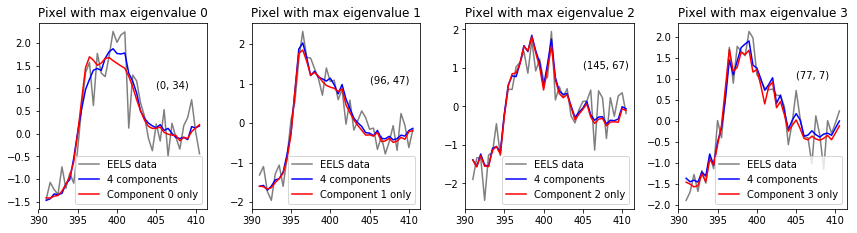

In [23]:
eigenvectors=PCA.components_
fig= plt.figure(figsize=(12,12))
ax=[]
#fig.suptitle('Datapoints with highest score for each component')


for i,eigenvector in enumerate(eigenvectors):
    ax.append(fig.add_subplot(4,4,i+1))
    indexes=np.unravel_index(np.argmax(PCAembeddings[:,:,i], axis=None), PCAembeddings[:,:,i].shape)
    ax[i].text(405,1,indexes)
    #ax[i].plot(data.ECut,PCA[0].mean_,color=[0,0,0,0.5])
    ax[i].plot(data.ECut,trainingforML[indexes],color=[0,0,0,0.5],label='EELS data')
    
    predicted=np.dot(PCAembeddings[indexes], eigenvectors) +PCA.mean_
    ax[i].plot(data.ECut,predicted,color=[0,0,1,1],label=str(numPCAcomp)+' components')
    weight=PCAembeddings[indexes][i]
    ax[i].plot(data.ECut,eigenvector*weight+PCA.mean_,color=[1,0,0,1],label='Component '+str(i)+' only')
    ax[i].set_title('Pixel with max eigenvalue '+str(i))
    ax[i].legend()
fig.tight_layout()